# Super Resolution UNET

<div class="alert alert-info">

This tutorial is available as an IPython notebook at [malaya-speech/example/super-resolution-unet](https://github.com/huseinzol05/malaya-speech/tree/master/example/super-resolution-unet).
    
</div>

<div class="alert alert-info">

This module is language independent, so it save to use on different languages. Pretrained models trained on multilanguages.
    
</div>

<div class="alert alert-warning">

This is an application of malaya-speech Pipeline, read more about malaya-speech Pipeline at [malaya-speech/example/pipeline](https://github.com/huseinzol05/malaya-speech/tree/master/example/pipeline).
    
</div>

### Dataset

Trained on English, Manglish and Bahasa podcasts with augmented noises, gathered at https://github.com/huseinzol05/malaya-speech/tree/master/data/podcast

Purpose of this module to increase sample rate.

In [1]:
import malaya_speech
import numpy as np
from malaya_speech import Pipeline
import IPython.display as ipd

In [2]:
import logging

logging.basicConfig(level=logging.INFO)

### List available UNET deep models

In [3]:
malaya_speech.super_resolution.available_unet()

INFO:malaya_speech.super_resolution:Only calculate SDR, ISR, SAR on voice sample. Higher is better.


Size (MB)  Quantized Size (MB)       SDR        ISR        SAR
srgan-128       7.37                 2.04  17.03345  22.330260  17.454372
srgan-256      29.50                 7.55  16.34558  22.067493  17.024390

We modified SRGAN to do 1D Convolution and use output distance as generator loss, originally use content loss.

### Load UNET deep model

```python
def unet(model: str = 'srgan-256', quantized: bool = False, **kwargs):
    """
    Load Super Resolution 4x deep learning UNET model.

    Parameters
    ----------
    model : str, optional (default='srgan-256')
        Model architecture supported. Allowed values:

        * ``'srgan-128'`` - srgan with 128 filter size and 16 residual blocks.
        * ``'srgan-256'`` - srgan with 256 filter size and 16 residual blocks.
    quantized : bool, optional (default=False)
        if True, will load 8-bit quantized model.
        Quantized model not necessary faster, totally depends on the machine.

    Returns
    -------
    result : malaya_speech.model.tf.UNET1D class
    """
```

In [4]:
model = malaya_speech.super_resolution.unet(model = 'srgan-256')
model_128 = malaya_speech.super_resolution.unet(model = 'srgan-128')

INFO:malaya_boilerplate.frozen_graph:running Users/huseinzolkepli/.cache/huggingface/hub using device /device:CPU:0
INFO:malaya_boilerplate.frozen_graph:running Users/huseinzolkepli/.cache/huggingface/hub using device /device:CPU:0


### Load Quantized deep model

To load 8-bit quantized model, simply pass `quantized = True`, default is `False`.

We can expect slightly accuracy drop from quantized model, and not necessary faster than normal 32-bit float model, totally depends on machine.

In [5]:
quantized_model = malaya_speech.super_resolution.unet(model = 'srgan-256', quantized = True)
quantized_model_128 = malaya_speech.super_resolution.unet(model = 'srgan-128', quantized = True)

INFO:malaya_boilerplate.frozen_graph:running Users/huseinzolkepli/.cache/huggingface/hub using device /device:CPU:0
INFO:malaya_boilerplate.frozen_graph:running Users/huseinzolkepli/.cache/huggingface/hub using device /device:CPU:0


### Important factor

1. Currently we only supported 4x super resolution, if input sample rate is 16k, output will become 16k * 4.
2. We trained on 11025 for input sample rate, 44100 for output sample rate.

### Predict

```python
def predict(self, input):
    """
    Enhance inputs, will return waveform.

    Parameters
    ----------
    input: np.array
        np.array or malaya_speech.model.frame.Frame.

    Returns
    -------
    result: np.array
    """
```

Let say we have a low sample rate audio,

In [6]:
sr = 44100
reduction_factor = 4

In [10]:
original_y, _ = malaya_speech.load('speech/44k/test-0.wav', sr = sr)
original_y = original_y[: sr * 4]
len(original_y) / sr

4.0

In [14]:
y, sr_ = malaya_speech.load('speech/44k/test-0.wav', sr = sr // reduction_factor)
y = y[:sr_ * 4]
ipd.Audio(y, rate = sr_)

In [12]:
%%time

output_256 = model(y)
ipd.Audio(output_256, rate = sr)

CPU times: user 24.9 s, sys: 2.96 s, total: 27.8 s
Wall time: 5.26 s


In [13]:
%%time

output_128 = model_128(y)
ipd.Audio(output_128, rate = sr)

CPU times: user 7.57 s, sys: 1.45 s, total: 9.02 s
Wall time: 2 s


Below is common technique people do upsampling using interpolate,

In [16]:
y_ = malaya_speech.resample(y, sr // reduction_factor, sr)

In [17]:
import librosa
import matplotlib.pyplot as plt

In [19]:
sampling_rate = 44100
fft_size = 2048
hop_size = 256
win_length = None
window = 'hann'
num_mels = 128
fmin = 0
fmax = None

mel_basis = librosa.filters.mel(
    sr=sampling_rate,
    n_fft=fft_size,
    n_mels=num_mels,
    fmin=fmin,
    fmax=fmax,
)

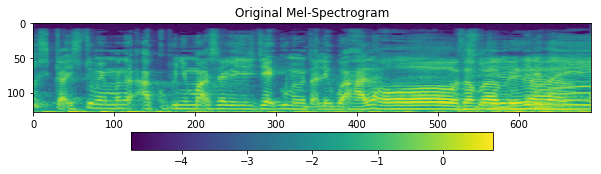

In [20]:
D = librosa.stft(
    original_y,
    n_fft=fft_size,
    hop_length=hop_size,
    win_length=win_length,
    window=window,
    pad_mode='reflect',
)
S, _ = librosa.magphase(D)
mel = np.log10(np.maximum(np.dot(mel_basis, S), 1e-10)).T
fig = plt.figure(figsize=(10, 8))
ax1 = fig.add_subplot(311)
ax1.set_title('Original Mel-Spectrogram')
im = ax1.imshow(np.rot90(mel), aspect='auto', interpolation='none')
fig.colorbar(mappable=im, shrink=0.65, orientation='horizontal', ax=ax1)
plt.show()

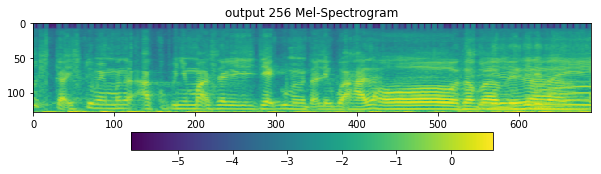

In [21]:
D = librosa.stft(
    output_256,
    n_fft=fft_size,
    hop_length=hop_size,
    win_length=win_length,
    window=window,
    pad_mode='reflect',
)
S, _ = librosa.magphase(D)
mel = np.log10(np.maximum(np.dot(mel_basis, S), 1e-10)).T
fig = plt.figure(figsize=(10, 8))
ax1 = fig.add_subplot(311)
ax1.set_title('output 256 Mel-Spectrogram')
im = ax1.imshow(np.rot90(mel), aspect='auto', interpolation='none')
fig.colorbar(mappable=im, shrink=0.65, orientation='horizontal', ax=ax1)
plt.show()

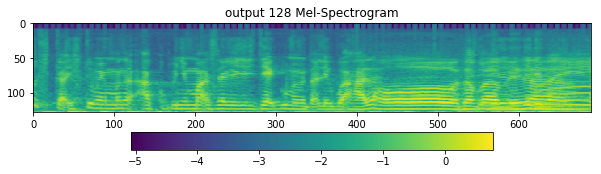

In [22]:
D = librosa.stft(
    output_128,
    n_fft=fft_size,
    hop_length=hop_size,
    win_length=win_length,
    window=window,
    pad_mode='reflect',
)
S, _ = librosa.magphase(D)
mel = np.log10(np.maximum(np.dot(mel_basis, S), 1e-10)).T
fig = plt.figure(figsize=(10, 8))
ax1 = fig.add_subplot(311)
ax1.set_title('output 128 Mel-Spectrogram')
im = ax1.imshow(np.rot90(mel), aspect='auto', interpolation='none')
fig.colorbar(mappable=im, shrink=0.65, orientation='horizontal', ax=ax1)
plt.show()

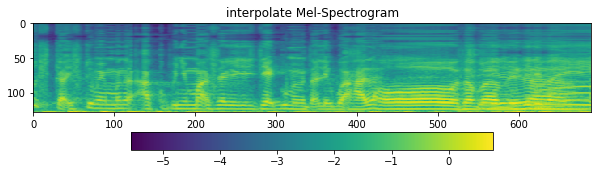

In [23]:
D = librosa.stft(
    y_,
    n_fft=fft_size,
    hop_length=hop_size,
    win_length=win_length,
    window=window,
    pad_mode='reflect',
)
S, _ = librosa.magphase(D)
mel = np.log10(np.maximum(np.dot(mel_basis, S), 1e-10)).T
fig = plt.figure(figsize=(10, 8))
ax1 = fig.add_subplot(311)
ax1.set_title('interpolate Mel-Spectrogram')
im = ax1.imshow(np.rot90(mel), aspect='auto', interpolation='none')
fig.colorbar(mappable=im, shrink=0.65, orientation='horizontal', ax=ax1)
plt.show()

### Try more examples

In [24]:
y, sr_ = malaya_speech.load('speech/call-centre/1.wav', sr = sr // reduction_factor)
y = y[sr_ * 5 :sr_ * 10]
sr_

11025

In [25]:
ipd.Audio(y, rate = sr_)

In [26]:
%%time

output = model(y)
ipd.Audio(output, rate = sr)

CPU times: user 30.1 s, sys: 3.39 s, total: 33.5 s
Wall time: 5.52 s


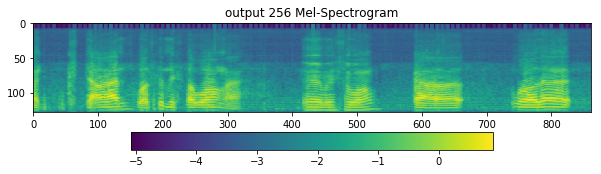

In [30]:
D = librosa.stft(
    output,
    n_fft=fft_size,
    hop_length=hop_size,
    win_length=win_length,
    window=window,
    pad_mode='reflect',
)
S, _ = librosa.magphase(D)
mel = np.log10(np.maximum(np.dot(mel_basis, S), 1e-10)).T
fig = plt.figure(figsize=(10, 8))
ax1 = fig.add_subplot(311)
ax1.set_title('output 256 Mel-Spectrogram')
im = ax1.imshow(np.rot90(mel), aspect='auto', interpolation='none')
fig.colorbar(mappable=im, shrink=0.65, orientation='horizontal', ax=ax1)
plt.show()

In [31]:
%%time

output = model_128(y)
ipd.Audio(output, rate = sr)

CPU times: user 9.3 s, sys: 1.67 s, total: 11 s
Wall time: 1.95 s


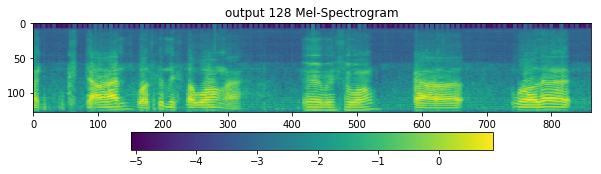

In [33]:
D = librosa.stft(
    output,
    n_fft=fft_size,
    hop_length=hop_size,
    win_length=win_length,
    window=window,
    pad_mode='reflect',
)
S, _ = librosa.magphase(D)
mel = np.log10(np.maximum(np.dot(mel_basis, S), 1e-10)).T
fig = plt.figure(figsize=(10, 8))
ax1 = fig.add_subplot(311)
ax1.set_title('output 128 Mel-Spectrogram')
im = ax1.imshow(np.rot90(mel), aspect='auto', interpolation='none')
fig.colorbar(mappable=im, shrink=0.65, orientation='horizontal', ax=ax1)
plt.show()

In [29]:
y_ = malaya_speech.resample(y, sr_, sr)
ipd.Audio(y_, rate = sr)

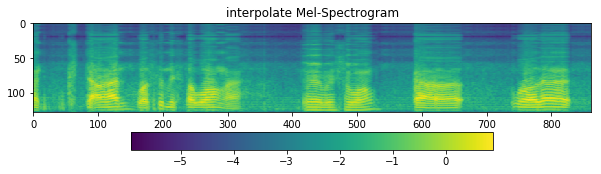

In [34]:
D = librosa.stft(
    y_,
    n_fft=fft_size,
    hop_length=hop_size,
    win_length=win_length,
    window=window,
    pad_mode='reflect',
)
S, _ = librosa.magphase(D)
mel = np.log10(np.maximum(np.dot(mel_basis, S), 1e-10)).T
fig = plt.figure(figsize=(10, 8))
ax1 = fig.add_subplot(311)
ax1.set_title('interpolate Mel-Spectrogram')
im = ax1.imshow(np.rot90(mel), aspect='auto', interpolation='none')
fig.colorbar(mappable=im, shrink=0.65, orientation='horizontal', ax=ax1)
plt.show()

### Use Pipeline

Incase your audio is too long and you do not want to burden your machine. So, you can use malaya-speech Pipeline to split the audio splitted to 3 seconds, predict one-by-one and combine after that.

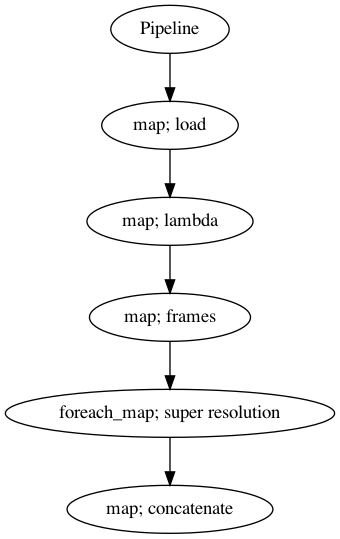

In [20]:
p = Pipeline()
pipeline = (
    p.map(malaya_speech.load, sr = sr // reduction_factor)
    .map(lambda x: x[0])
    .map(malaya_speech.generator.frames, frame_duration_ms = 3000, sample_rate = sr // reduction_factor)
    .foreach_map(model_128)
    .map(np.concatenate)
)
p.visualize()

In [21]:
%%time

results = p('speech/podcast/nusantara.wav')

CPU times: user 20.2 s, sys: 2.52 s, total: 22.7 s
Wall time: 4.19 s


In [22]:
results.keys()

dict_keys(['load', '<lambda>', 'frames', 'super-resolution', 'concatenate'])

In [23]:
ipd.Audio(results['concatenate'], rate = sr)

In [24]:
ipd.Audio(results['<lambda>'], rate = sr // reduction_factor)

In [25]:
y_ = malaya_speech.resample(results['<lambda>'], sr // reduction_factor, sr)
ipd.Audio(y_, rate = sr)